In [1]:
from __future__ import absolute_import, division, print_function

import os
import numpy as np
import argparse
import time
import tensorflow as tf
import errno
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import tensorflow.contrib.slim as slim
from bts_dataloader import *

sys.path.append("./custom_layer/")
import _local_planar_guidance_grad

lpg = tf.load_op_library('custom_layer/build/liblpg.so')

model_name = 'bts_nyu_v2'
encoder = 'densenet161_bts'
data_path = '../dataset/nyu_depth_v2/official_splits/test/'
dataset = 'nyu'
filenames_file = '../train_test_inputs/nyudepthv2_test_files_with_gt_small.txt' 
model_name = 'bts_nyu_v2'
checkpoint_path = './models/bts_nyu_v2/model'
input_height = 480
input_width = 640
max_depth = 10
do_kb_crop = False
save_lpg = False

In [2]:
def get_num_lines(file_path):
    f = open(file_path, 'r')
    lines = f.readlines()
    f.close()
    return len(lines)

In [3]:
from collections import namedtuple
bts_parameters = namedtuple('parameters', 'encoder, '
                                          'height, width, '
                                          'max_depth, '
                                          'batch_size, '
                                          'dataset, '
                                          'num_gpus, '
                                          'num_threads, '
                                          'num_epochs, ')
params = bts_parameters(
        encoder=encoder,
        height=input_height,
        width=input_width,
        batch_size=None,
        dataset=dataset,
        max_depth=max_depth,
        num_gpus=None,
        num_threads=None,
        num_epochs=None)

dataloader = BtsDataloader(data_path, None, filenames_file, params, 'test', do_kb_crop=do_kb_crop)
dataloader_iter = dataloader.loader.make_initializable_iterator()
iter_init_op = dataloader_iter.initializer
image, focal = dataloader_iter.get_next()

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
class BtsModel(object):

    def __init__(self, params, mode, image, depth_gt, focal, reuse_variables=None, model_index=0, bn_training=False):
        self.params = params
        self.mode = mode
        self.max_depth = self.params.max_depth

        self.input_image = image
        self.depth_gt = depth_gt
        self.focal = tf.cast(focal, tf.float32)
        self.model_collection = ['model_' + str(model_index)]

        self.reuse_variables = reuse_variables
        self.bn_training = bn_training
        self.is_training = True if mode == 'train' else False

        self.build_model(net_input=self.input_image, reuse=self.reuse_variables)

        if self.mode == 'test':
            return

        self.build_losses()
        self.build_summaries()

    def upsample_nn(self, x, ratio):
        s = tf.shape(x)
        h = s[1]
        w = s[2]
        return tf.image.resize_nearest_neighbor(x, [h * ratio, w * ratio], align_corners=True)
    
    def downsample_nn(self, x, ratio):
        s = tf.shape(x)
        h = tf.cast(s[1] / ratio, tf.int32)
        w = tf.cast(s[2] / ratio, tf.int32)
        return tf.image.resize_nearest_neighbor(x, [h, w], align_corners=True)
    
    def conv(self, x, num_out_layers, kernel_size, stride, activation_fn=tf.nn.elu, normalizer_fn=None):
        p = np.floor((kernel_size - 1) / 2).astype(np.int32)
        p_x = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]])
        return slim.conv2d(p_x, num_out_layers, kernel_size, stride, 'VALID', activation_fn=activation_fn, normalizer_fn=normalizer_fn)

    def atrous_conv(self, x, num_out_layers, kernel_size, rate, apply_bn_first=True):
        pk = np.floor((kernel_size - 1) / 2).astype(np.int32)
        pr = rate - 1
        p = pk + pr
        out = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]])

        if apply_bn_first is True:
            out = slim.batch_norm(out)

        out = tf.nn.relu(out)
        out = slim.conv2d(out, num_out_layers * 2, 1, 1, 'VALID')
        out = slim.batch_norm(out)
        out = tf.nn.relu(out)
        out = slim.conv2d(out, num_out_layers, kernel_size=kernel_size, stride=1, rate=rate, padding='VALID',
                          activation_fn=None, normalizer_fn=None)

        return out

    def upconv(self, x, num_out_layers, kernel_size, scale, activation_fn=tf.nn.elu, normalizer_fn=None):
        upsample = self.upsample_nn(x, scale)
        conv = self.conv(upsample, num_out_layers, kernel_size, 1, activation_fn=activation_fn, normalizer_fn=normalizer_fn)
        return conv

    @slim.add_arg_scope
    def denseconv(self, x, num_filters, kernel_size, stride=1, dilation_rate=1, dropout_rate=None, scope=None):
        with tf.variable_scope(scope, 'xx', [x]) as sc:
            out = slim.batch_norm(x, is_training=False)
            out = tf.nn.relu(out)
            out = slim.conv2d(out, num_filters, kernel_size, rate=dilation_rate, activation_fn=None)
            if dropout_rate:
                out = tf.nn.dropout(out)
            return out

    @slim.add_arg_scope
    def denseconv_block(self, x, num_filters, dilation_rate=1, scope=None):
        with tf.variable_scope(scope, 'conv_blockx', [x]) as sc:
            out = self.denseconv(x, num_filters * 4, 1, scope='x1')
            out = self.denseconv(out, num_filters, 3, dilation_rate=dilation_rate, scope='x2')
            out = tf.concat([x, out], axis=3)
            return out

    @slim.add_arg_scope
    def dense_block(self, x, num_layers, num_filters, growth_rate, dilation_rate=1, grow_num_filters=True, scope=None):
        with tf.variable_scope(scope, 'dense_blockx', [x]) as sc:
            out = x
            for i in range(num_layers):
                branch = i + 1
                out = self.denseconv_block(out, growth_rate, dilation_rate=dilation_rate,
                                           scope='conv_block' + str(branch))
                if grow_num_filters:
                    num_filters += growth_rate
            return out, num_filters

    @slim.add_arg_scope
    def transition_block(self, x, num_filters, compression=1.0, do_pooling=True, scope=None):
        num_filters = int(num_filters * compression)
        with tf.variable_scope(scope, 'transition_blockx', [x]) as sc:
            out = self.denseconv(x, num_filters, 1, scope='blk')
            if do_pooling:
                out = slim.avg_pool2d(out, 2)
            return out, num_filters

    @slim.add_arg_scope
    def reduction_1x1(self, net, num_filters, is_final=False):
        while num_filters >= 4:
            if num_filters < 8:
                if is_final:
                    net = self.conv(net, 1, 1, 1, activation_fn=tf.nn.sigmoid)
                else:
                    net = self.conv(net, 3, 1, 1, activation_fn=None)
                    theta = tf.nn.sigmoid(net[:, :, :, 0]) * 3.1415926535 / 6
                    phi = tf.nn.sigmoid(net[:, :, :, 1]) * 3.1415926535 * 2
                    dist = tf.nn.sigmoid(net[:, :, :, 2]) * self.max_depth
                    n1 = tf.expand_dims(tf.multiply(tf.math.sin(theta), tf.math.cos(phi)), 3)
                    n2 = tf.expand_dims(tf.multiply(tf.math.sin(theta), tf.math.sin(phi)), 3)
                    n3 = tf.expand_dims(tf.math.cos(theta), 3)
                    n4 = tf.expand_dims(dist, 3)
                    net = tf.concat([n1, n2, n3, n4], axis=3)
                break
            else:
                net = self.conv(net, num_filters, 1, 1)

            num_filters = num_filters / 2

        return net

    def get_depth(self, x):
        depth = self.max_depth * self.conv(x, 1, 3, 1, tf.nn.sigmoid, normalizer_fn=None)
        if self.params.dataset == 'kitti':
            focal_expanded = tf.expand_dims(self.focal, 1)
            focal_expanded = tf.expand_dims(focal_expanded, 1)
            focal_expanded = tf.expand_dims(focal_expanded, 1)
            depth = depth * focal_expanded / 715.0873 # Average focal length in KITTI Eigen training set
        return depth
    
    def densenet(self, inputs, reduction=None, growth_rate=None, num_filters=None, num_layers=None, dropout_rate=None,
                 is_training=True, reuse=None, scope=None):

        assert reduction is not None
        assert growth_rate is not None
        assert num_filters is not None
        assert num_layers is not None

        compression = 1.0 - reduction
        num_dense_blocks = len(num_layers)

        batch_norm_params = {'is_training': False,
                             'scale': True,
                             'decay': 0.99,
                             'epsilon': 1.1e-5,
                             'fused': True, }

        with tf.variable_scope(scope, 'densenetxxx', [inputs], reuse=reuse) as sc:
            with slim.arg_scope([slim.dropout], is_training=is_training),\
                 slim.arg_scope([slim.batch_norm], **batch_norm_params),\
                 slim.arg_scope([slim.conv2d], weights_regularizer=slim.l2_regularizer(1e-4), activation_fn=None, biases_initializer=None):

                skips = []

                net = inputs

                # Initial convolution
                net = slim.conv2d(net, num_filters, 7, stride=2, scope='conv1')  # H/2
                net = slim.batch_norm(net, is_training=False)
                net = tf.nn.relu(net)

                skips.append(net)

                net = slim.max_pool2d(net, 3, stride=2, padding='SAME')  # H/4
                skips.append(net)

                # Blocks
                for i in range(num_dense_blocks - 1):  # i:0 H/8, i:1 H/16, i:2 H/32
                    do_pooling = True
                    dilation_rate = 1

                    net, num_filters = self.dense_block(net, num_layers[i], num_filters, growth_rate,
                                                        dilation_rate=dilation_rate, scope='dense_block' + str(i + 1))

                    # Add transition_block
                    net, num_filters = self.transition_block(net, num_filters, compression=compression,
                                                             do_pooling=do_pooling,
                                                             scope='transition_block' + str(i + 1))
                    if i < num_dense_blocks - 2:
                        skips.append(net)

                net, num_filters = self.dense_block(net, num_layers[-1], num_filters, growth_rate,
                                                    scope='dense_block' + str(num_dense_blocks))

                with tf.variable_scope('final_block', [inputs]):
                    net = slim.batch_norm(net, is_training=False)
                    net = tf.nn.relu(net)

                return net, skips

    @slim.add_arg_scope
    def bts(self, dense_features, skips, num_filters=256):
        batch_norm_params = {'is_training': self.bn_training,
                             'scale': True,
                             'decay': 0.99,
                             'epsilon': 1.1e-5,
                             'fused': True, }

        with slim.arg_scope([slim.batch_norm], **batch_norm_params):
            conv = self.conv
            atrous_conv = self.atrous_conv
            upconv = self.upconv

            upconv5 = upconv(dense_features, num_filters, 3, 2)  # H/16
            upconv5 = slim.batch_norm(upconv5)
            concat5 = tf.concat([upconv5, skips[3]], 3)
            iconv5 = conv(concat5, num_filters, 3, 1)

            num_filters = num_filters / 2

            upconv4 = upconv(iconv5, num_filters, 3, 2)  # H/8
            upconv4 = slim.batch_norm(upconv4)
            concat4 = tf.concat([upconv4, skips[2]], 3)
            iconv4 = conv(concat4, num_filters, 3, 1)
            iconv4 = slim.batch_norm(iconv4)

            daspp_3 = atrous_conv(iconv4, num_filters / 2, kernel_size=3, rate=3, apply_bn_first=False)
            concat4_2 = tf.concat([concat4, daspp_3], 3)
            daspp_6 = atrous_conv(concat4_2, num_filters / 2, kernel_size=3, rate=6)
            concat4_3 = tf.concat([concat4_2, daspp_6], 3)
            daspp_12 = atrous_conv(concat4_3, num_filters / 2, kernel_size=3, rate=12)
            concat4_4 = tf.concat([concat4_3, daspp_12], 3)
            daspp_18 = atrous_conv(concat4_4, num_filters / 2, kernel_size=3, rate=18)
            concat4_5 = tf.concat([concat4_4, daspp_18], 3)
            daspp_24 = atrous_conv(concat4_5, num_filters / 2, kernel_size=3, rate=24)
            concat4_daspp = tf.concat([iconv4, daspp_3, daspp_6, daspp_12, daspp_18, daspp_24], 3)
            daspp_feat = conv(concat4_daspp, num_filters / 2, 3, 1)

            plane_eq_8x8 = self.reduction_1x1(daspp_feat, num_filters / 2)
            plane_normal_8x8 = tf.nn.l2_normalize(plane_eq_8x8[:, :, :, 0:3], axis=3)
            plane_dist_8x8 = plane_eq_8x8[:, :, :, 3]
            plane_eq_8x8 = tf.concat([plane_normal_8x8, tf.expand_dims(plane_dist_8x8, 3)], 3)
            depth_8x8 = lpg.local_planar_guidance(plane_eq_8x8, upratio=8, focal=self.focal)
            depth_8x8_scaled = tf.expand_dims(depth_8x8, 3) / self.max_depth
            depth_8x8_scaled_ds = self.downsample_nn(depth_8x8_scaled, 4)

            num_filters = num_filters / 2

            upconv3 = upconv(daspp_feat, num_filters, 3, 2)  # H/4
            upconv3 = slim.batch_norm(upconv3)
            concat3 = tf.concat([upconv3, skips[1], depth_8x8_scaled_ds], 3)
            iconv3 = conv(concat3, num_filters, 3, 1)

            plane_eq_4x4 = self.reduction_1x1(iconv3, num_filters / 2)
            plane_normal_4x4 = tf.nn.l2_normalize(plane_eq_4x4[:, :, :, 0:3], axis=3)
            plane_dist_4x4 = plane_eq_4x4[:, :, :, 3]
            plane_eq_4x4 = tf.concat([plane_normal_4x4, tf.expand_dims(plane_dist_4x4, 3)], 3)
            depth_4x4 = lpg.local_planar_guidance(plane_eq_4x4, upratio=4, focal=self.focal)
            depth_4x4_scaled = tf.expand_dims(depth_4x4, 3) / self.max_depth
            depth_4x4_scaled_ds = self.downsample_nn(depth_4x4_scaled, 2)

            num_filters = num_filters / 2

            upconv2 = upconv(iconv3, num_filters, 3, 2)  # H/2
            upconv2 = slim.batch_norm(upconv2)
            concat2 = tf.concat([upconv2, skips[0], depth_4x4_scaled_ds], 3)
            iconv2 = conv(concat2, num_filters, 3, 1)

            plane_eq_2x2 = self.reduction_1x1(iconv2, num_filters / 2)
            plane_normal_2x2 = tf.nn.l2_normalize(plane_eq_2x2[:, :, :, 0:3], axis=3)
            plane_dist_2x2 = plane_eq_2x2[:, :, :, 3]
            plane_eq_2x2 = tf.concat([plane_normal_2x2, tf.expand_dims(plane_dist_2x2, 3)], 3)
            depth_2x2 = lpg.local_planar_guidance(plane_eq_2x2, upratio=2, focal=self.focal)
            depth_2x2_scaled = tf.expand_dims(depth_2x2, 3) / self.max_depth

            num_filters = num_filters / 2

            upconv1 = upconv(iconv2, num_filters, 3, 2)  # H
            reduc1x1 = self.reduction_1x1(upconv1, num_filters, is_final=True)
            concat1 = tf.concat([upconv1, reduc1x1, depth_2x2_scaled, depth_4x4_scaled, depth_8x8_scaled], 3)
            iconv1 = conv(concat1, num_filters, 3, 1)

            self.depth_est = self.get_depth(iconv1)
            self.lpg2x2 = depth_2x2_scaled
            self.lpg4x4 = depth_4x4_scaled
            self.lpg8x8 = depth_8x8_scaled
            self.reduc1x1 = reduc1x1

            print("==================================")
            print(" upconv5 in/out: {} / {}".format(dense_features.shape[-1], upconv5.shape[-1]))
            print("  iconv5 in/out: {} / {}".format(concat5.shape[-1], iconv5.shape[-1]))
            print(" upconv4 in/out: {} / {}".format(iconv5.shape[-1], upconv4.shape[-1]))
            print("  iconv4 in/out: {} / {}".format(concat4.shape[-1], iconv4.shape[-1]))
            print("    aspp in/out: {} / {}".format(concat4_daspp.shape[-1], daspp_feat.shape[-1]))
            print("reduc8x8 in/out: {} / {}".format(daspp_feat.shape[-1], plane_eq_8x8.shape[-1]))
            print("  lpg8x8 in/out: {} / {}".format(plane_eq_8x8.shape[-1], 1))
            print(" upconv3 in/out: {} / {}".format(daspp_feat.shape[-1], upconv3.shape[-1]))
            print("  iconv3 in/out: {} / {}".format(concat3.shape[-1], iconv3.shape[-1]))
            print("reduc4x4 in/out: {} / {}".format(iconv3.shape[-1], plane_eq_4x4.shape[-1]))
            print("  lpg4x4 in/out: {} / {}".format(plane_eq_4x4.shape[-1], 1))
            print(" upconv2 in/out: {} / {}".format(iconv3.shape[-1], upconv2.shape[-1]))
            print("  iconv2 in/out: {} / {}".format(concat2.shape[-1], iconv2.shape[-1]))
            print("reduc2x2 in/out: {} / {}".format(iconv2.shape[-1], plane_eq_2x2.shape[-1]))
            print("  lpg2x2 in/out: {} / {}".format(plane_eq_2x2.shape[-1], 1))
            print(" upconv1 in/out: {} / {}".format(iconv2.shape[-1], upconv1.shape[-1]))
            print("reduc1x1 in/out: {} / {}".format(upconv1.shape[-1], reduc1x1.shape[-1]))
            print("  iconv1 in/out: {} / {}".format(concat1.shape[-1], iconv1.shape[-1]))
            print("   depth in/out: {} / {}".format(iconv1.shape[-1], self.depth_est.shape[-1]))
            print("==================================")

    def build_resnet101_bts(self, net_input, reuse):
        batch_norm_params = {
            'is_training': False,
            'decay': 0.997,
            'epsilon': 1e-5,
            'scale': True,
            'fused': True,  # Use fused batch norm if possible.
        }
        with tf.variable_scope('encoder'):
            with slim.arg_scope([slim.conv2d],
                                weights_regularizer=slim.l2_regularizer(1e-4),
                                weights_initializer=slim.variance_scaling_initializer(),
                                activation_fn=tf.nn.relu,
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=batch_norm_params),\
                 slim.arg_scope([slim.batch_norm], **batch_norm_params),\
                 slim.arg_scope([slim.max_pool2d], padding='SAME'):

                dense_features, skips, endpoints = resnet_v1_101(net_input, global_pool=False, spatial_squeeze=False,
                                                                 is_training=self.is_training, reuse=reuse, scope='resnet101')

        with tf.variable_scope('decoder'):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.elu):
                self.bts(dense_features, skips, num_filters=512)

    def build_resnet50_bts(self, net_input, reuse):
        batch_norm_params = {
            'is_training': False,
            'decay': 0.997,
            'epsilon': 1e-5,
            'scale': True,
            'fused': True,  # Use fused batch norm if possible.
        }
        with tf.variable_scope('encoder'):
            with slim.arg_scope([slim.conv2d],
                                weights_regularizer=slim.l2_regularizer(1e-4),
                                weights_initializer=slim.variance_scaling_initializer(),
                                activation_fn=tf.nn.relu,
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=batch_norm_params), \
                 slim.arg_scope([slim.batch_norm], **batch_norm_params), \
                 slim.arg_scope([slim.max_pool2d], padding='SAME'):

                dense_features, skips, endpoints = resnet_v1_50(net_input, global_pool=False, spatial_squeeze=False,
                                                                is_training=self.is_training, reuse=reuse, scope='resnet50')

        with tf.variable_scope('decoder'):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.elu):
                self.bts(dense_features, skips, num_filters=256)

    def build_densenet121_bts(self, net_input, reuse):
        with tf.variable_scope('encoder'):
            dense_features, skips = self.densenet(net_input, reduction=0.5, growth_rate=32,
                                                  num_filters=self.num_filters, num_layers=[6, 12, 24, 16],
                                                  is_training=self.is_training, reuse=reuse, scope='densenet121')

        with tf.variable_scope('decoder'):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.elu):
                self.bts(dense_features, skips, num_filters=256)

    def build_densenet161_bts(self, net_input, reuse):
        with tf.variable_scope('encoder'):
            dense_features, skips = self.densenet(net_input, reduction=0.5, growth_rate=48,
                                                  num_filters=self.num_filters, num_layers=[6, 12, 36, 24],
                                                  is_training=self.is_training, reuse=reuse, scope='densenet161')

        with tf.variable_scope('decoder'):
            with slim.arg_scope([slim.conv2d, slim.conv2d_transpose], activation_fn=tf.nn.elu):
                self.bts(dense_features, skips, num_filters=512)

    def build_model(self, net_input, reuse):
        with tf.variable_scope('model', reuse=reuse):
            if self.params.encoder == 'densenet161_bts':
                self.num_filters = 96
                self.build_densenet161_bts(net_input=net_input, reuse=reuse)
            elif self.params.encoder == 'densenet121_bts':
                self.num_filters = 64
                self.build_densenet121_bts(net_input=net_input, reuse=reuse)
            elif self.params.encoder == 'resnet101_bts':
                self.build_resnet101_bts(net_input=net_input, reuse=reuse)
            elif self.params.encoder == 'resnet50_bts':
                self.build_resnet50_bts(net_input=net_input, reuse=reuse)
            else:
                return None

    def build_losses(self):
        with tf.variable_scope('losses', reuse=self.reuse_variables):

            if self.params.dataset == 'nyu':
                self.mask = self.depth_gt > 0.1
            else:
                self.mask = self.depth_gt > 1.0

            depth_gt_masked = tf.boolean_mask(self.depth_gt, self.mask)
            depth_est_masked = tf.boolean_mask(self.depth_est, self.mask)

            d = tf.log(depth_est_masked) - tf.log(depth_gt_masked)  # Best

            self.silog_loss = tf.sqrt(tf.reduce_mean(d ** 2) - 0.85 * (tf.reduce_mean(d) ** 2)) * 10.0
            self.total_loss = self.silog_loss

    def build_summaries(self):
        with tf.device('/cpu:0'):
            tf.summary.scalar('silog_loss', self.silog_loss, collections=self.model_collection)
            depth_gt = tf.where(self.depth_gt < 1e-3, self.depth_gt * 0 + 1e3, self.depth_gt)
            tf.summary.image('depth_gt', 1 / depth_gt, max_outputs=4, collections=self.model_collection)
            tf.summary.image('depth_est', 1 / self.depth_est, max_outputs=4, collections=self.model_collection)
            tf.summary.image('reduc1x1', 1 / self.reduc1x1, max_outputs=4, collections=self.model_collection)
            tf.summary.image('lpg2x2', 1 / self.lpg2x2, max_outputs=4, collections=self.model_collection)
            tf.summary.image('lpg4x4', 1 / self.lpg4x4, max_outputs=4, collections=self.model_collection)
            tf.summary.image('lpg8x8', 1 / self.lpg8x8, max_outputs=4, collections=self.model_collection)
            tf.summary.image('image', self.input_image, max_outputs=4, collections=self.model_collection)

In [6]:
model = BtsModel(params, 'test', image, None, focal=focal, bn_training=False)

 upconv5 in/out: 2208 / 512
  iconv5 in/out: 896 / 512
 upconv4 in/out: 512 / 256
  iconv4 in/out: 448 / 256
    aspp in/out: 896 / 128
reduc8x8 in/out: 128 / 4
  lpg8x8 in/out: 4 / 1
 upconv3 in/out: 128 / 128
  iconv3 in/out: 225 / 128
reduc4x4 in/out: 128 / 4
  lpg4x4 in/out: 4 / 1
 upconv2 in/out: 128 / 64
  iconv2 in/out: 161 / 64
reduc2x2 in/out: 64 / 4
  lpg2x2 in/out: 4 / 1
 upconv1 in/out: 64 / 32
reduc1x1 in/out: 32 / 1
  iconv1 in/out: 36 / 32
   depth in/out: 32 / 1


In [7]:
# SESSION
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)

In [8]:
# INIT
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [9]:
# SAVER
train_saver = tf.train.Saver()

In [10]:
restore_path = checkpoint_path

# RESTORE
train_saver.restore(sess, restore_path)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./models/bts_nyu_v2/model


In [11]:
num_test_samples = get_num_lines(filenames_file)

In [13]:
with open(filenames_file) as f:
    lines = f.readlines()

print('Now testing {} files with {}'.format(num_test_samples, checkpoint_path))

Now testing 100 files with ./models/bts_nyu_v2/model


In [15]:
sess.run(iter_init_op)

In [16]:
pred_depths = []
pred_8x8s = []
pred_4x4s = []
pred_2x2s = []

In [17]:
start_time = time.time()
print('Processing images..')
for s in tqdm(range(num_test_samples)):
    depth, pred_8x8, pred_4x4, pred_2x2 = sess.run([model.depth_est, model.lpg8x8, model.lpg4x4, model.lpg2x2])
    pred_depths.append(depth[0].squeeze())

    pred_8x8s.append(pred_8x8[0].squeeze())
    pred_4x4s.append(pred_4x4[0].squeeze())
    pred_2x2s.append(pred_2x2[0].squeeze())

print('Done.')

Processing images..


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]

Done.


# Saving result pngs

In [20]:
save_name = 'result_' + model_name
if not os.path.exists(os.path.dirname(save_name)):
    try:
        os.mkdir(save_name)
        os.mkdir(save_name + '/raw')
        os.mkdir(save_name + '/cmap')
        os.mkdir(save_name + '/rgb')
        os.mkdir(save_name + '/gt')
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [26]:
image = cv2.imread('../dataset/nyu_depth_v2/official_splits/test/bathroom/rgb_00045.jpg')

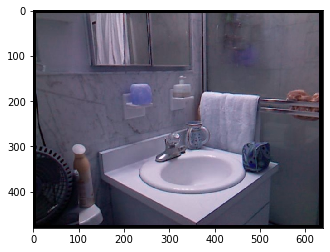

In [27]:
plt.imshow(image)

In [29]:
os.path.join(data_path, lines[0].split()[1])

'../dataset/nyu_depth_v2/official_splits/test/bathroom/sync_depth_00045.png'

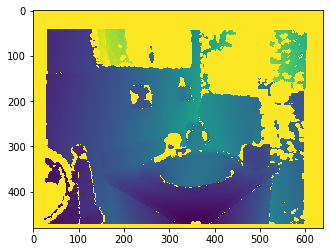

In [48]:
gt = cv2.imread('../dataset/nyu_depth_v2/official_splits/test/bathroom/sync_depth_00045.png',cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0
gt[gt == 0] = np.amax(gt)
plt.imshow(gt)

In [21]:
for s in tqdm(range(num_test_samples)):
    if dataset == 'kitti':
        date_drive = lines[s].split('/')[1]
        filename_pred_png = save_name + '/raw/' + date_drive + '_' + lines[s].split()[0].split('/')[-1].replace('.jpg', '.png')
        filename_cmap_png = save_name + '/cmap/' + date_drive + '_' + lines[s].split()[0].split('/')[-1].replace('.jpg', '.png')
        filename_image_png = save_name + '/rgb/' + date_drive + '_' + lines[s].split()[0].split('/')[-1]
    elif dataset == 'kitti_benchmark':
        filename_pred_png = save_name + '/raw/' + lines[s].split()[0].split('/')[-1].replace('.jpg', '.png')
        filename_cmap_png = save_name + '/cmap/' + lines[s].split()[0].split('/')[-1].replace('.jpg', '.png')
        filename_image_png = save_name + '/rgb/' + lines[s].split()[0].split('/')[-1]
    else:
        scene_name = lines[s].split()[0].split('/')[0]
        filename_pred_png = save_name + '/raw/' + scene_name + '_' + lines[s].split()[0].split('/')[1].replace('.jpg', '.png')
        filename_cmap_png = save_name + '/cmap/' + scene_name + '_' + lines[s].split()[0].split('/')[1].replace('.jpg', '.png')
        filename_gt_png = save_name + '/gt/' + scene_name + '_' + lines[s].split()[0].split('/')[1].replace('.jpg', '.png')
        filename_image_png = save_name + '/rgb/' + scene_name + '_' + lines[s].split()[0].split('/')[1]

    rgb_path = os.path.join(data_path, lines[s].split()[0])
    image = cv2.imread(rgb_path)
    if dataset == 'nyu':
        gt_path = os.path.join(data_path, lines[s].split()[1])
        gt = cv2.imread(gt_path, -1).astype(np.float32) / 1000.0 # Visualization purpose only
        gt[gt == 0] = np.amax(gt)

    pred_depth = pred_depths[s]
    pred_8x8 = pred_8x8s[s]
    pred_4x4 = pred_4x4s[s]
    pred_2x2 = pred_2x2s[s]

    if dataset == 'kitti' or dataset == 'kitti_benchmark':
        pred_depth_scaled = pred_depth * 256.0
    else:
        pred_depth_scaled = pred_depth * 1000.0

    pred_depth_scaled = pred_depth_scaled.astype(np.uint16)
    cv2.imwrite(filename_pred_png, pred_depth_scaled, [cv2.IMWRITE_PNG_COMPRESSION, 0])

    if save_lpg:
        cv2.imwrite(filename_image_png, image[10:-1 - 9, 10:-1 - 9, :])
        if dataset == 'nyu':
            plt.imsave(filename_gt_png, np.log10(gt[10:-1 - 9, 10:-1 - 9]), cmap='Greys')
            pred_depth_cropped = pred_depth[10:-1 - 9, 10:-1 - 9]
            plt.imsave(filename_cmap_png, np.log10(pred_depth_cropped), cmap='Greys')
            pred_8x8_cropped = pred_8x8[10:-1 - 9, 10:-1 - 9]
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_8x8.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_8x8_cropped), cmap='Greys')
            pred_4x4_cropped = pred_4x4[10:-1 - 9, 10:-1 - 9]
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_4x4.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_4x4_cropped), cmap='Greys')
            pred_2x2_cropped = pred_2x2[10:-1 - 9, 10:-1 - 9]
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_2x2.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_2x2_cropped), cmap='Greys')
        else:
            plt.imsave(filename_cmap_png, np.log10(pred_depth), cmap='Greys')
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_8x8.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_8x8), cmap='Greys')
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_4x4.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_4x4), cmap='Greys')
            filename_lpg_cmap_png = filename_cmap_png.replace('.png', '_2x2.png')
            plt.imsave(filename_lpg_cmap_png, np.log10(pred_2x2), cmap='Greys')

100%|██████████| 100/100 [00:01<00:00, 76.09it/s]


In [50]:
!pwd

/data/BTS/bts/tensorflow


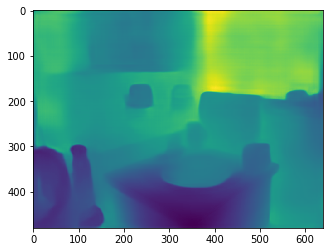

In [53]:
image = cv2.imread('result_bts_nyu_v2/raw/bathroom_rgb_00045.png',cv2.IMREAD_UNCHANGED)
plt.imshow(image)